In [99]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
#sns.set_theme()
sns.set_theme(style="whitegrid", palette="dark")
import matplotlib.patches as mpatches
import pandas as pd
import os


In [100]:
combined_dir =  "C:/Users/stell/OneDrive/desktop/CANS_LAB/BETTER"
full_output  = 'combined_filtered_ALL.csv'


df_combined = pd.read_csv(full_output)#, index = False)

In [101]:
model = LinearRegression(fit_intercept = True)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


Model score (R²):  0.9999973431611133
CV Score: [0.99999695 0.99999826 0.999996   0.99999833 0.99999818]
Model coefficients: [ 0.84975302  0.01376182  0.14106207 -0.00457112]
Model intercept: 0.002808935532257806


cv pred [ 0.1504629   0.25156166  0.71482529 ... 58.46210526 58.65242808
 59.01886412]
standard deviation:  27.60309811626626
mean -0.06027673926011023


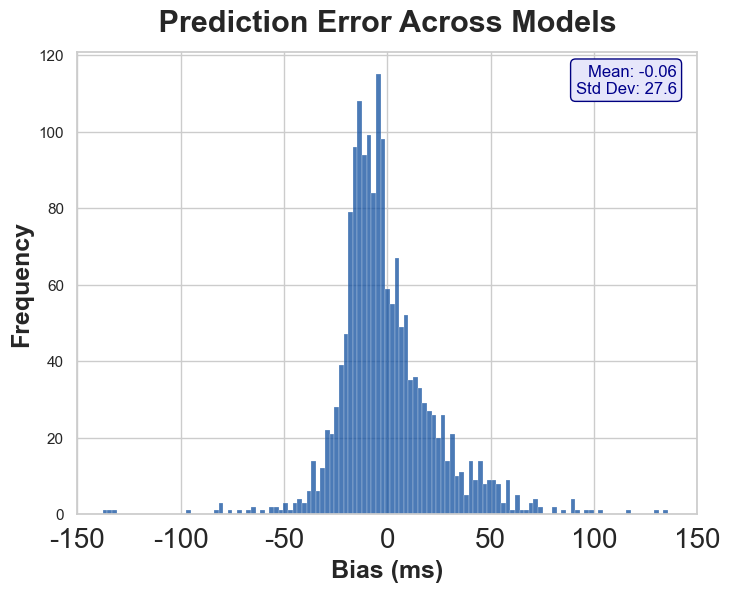

In [123]:
from scipy import stats
x_vector = df_combined[['MFA_Start', 'Vosk_Start', 'Wav2vec2_start', 'WhisperX_start']]


y_vector = df_combined['tmin']

# Using 70% data for training and 30% for testing
# Random state is a constant integer so training data will be constant for every run
x_vec_train, x_vec_test, y_vec_train, y_vec_test = train_test_split(x_vector, y_vector, test_size = 0.30, random_state = 42 )

fitted_model = model.fit(x_vec_train, y_vec_train)

score = model.score(x_vec_test, y_vec_test)
coef = model.coef_
intercept = model.intercept_
        
cv_score = cross_val_score(model, x_vector, y_vector, cv=kf)
y_pred = cross_val_predict(model, x_vector, y_vector, cv=kf)


    
print(f"Model score (R²): {score: }")
print(f"CV Score: {cv_score}")
print(f"Model coefficients: {coef}")
print(f"Model intercept: {intercept}")
print("\n")
print("cv pred", y_pred)


bias_cv = (y_vector - y_pred)

bias_sd = np.std(bias_cv)

print("standard deviation: ", bias_sd * 1000)
print ("mean", np.mean(bias_cv) * 1000)

plt.figure(figsize=(8, 6))

#plt.hist(bias_cv, bins = 1000,color='blue')
sns.histplot(bias_cv, bins = 250, color = '#0e4d9e', edgecolor = 'white')


#Make x-axis to be labelled in milliseconds
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x*1000:.0f}"))


plt.xlim(-0.15,0.15)
plt.xticks(np.arange(-0.15,0.20, 0.050), fontsize = 20)


plt.title(f" Prediction Error Across Models ", fontsize = 22, weight = 'bold', pad = 15)
plt.xlabel("Bias (ms)", fontsize = 18, weight = 'bold')
plt.ylabel("Frequency", fontsize = 18, weight = 'bold')

plt.text(0.14, 110, f'Mean: -0.06\nStd Dev: 27.6', 
         fontsize=12, color='darkblue', ha='right',
         bbox=dict(boxstyle="round,pad=0.3", fc="lavender", ec="navy"))


#plt.show()
plt.savefig('residuals.png')




C:\Users\stell\AppData\Local\Temp\ipykernel_15116\2638476096.py:26: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(x='Model', y= 'Bias (ms)', data=df_long, hue = 'Model', palette=palette)


Models ranked by least bias (closest to manual):
Model
Vosk_Start        0.004979
Wav2vec2_start    0.005238
MFA_Start         0.005496
WhisperX_start    0.047722
Name: Bias (ms), dtype: float64


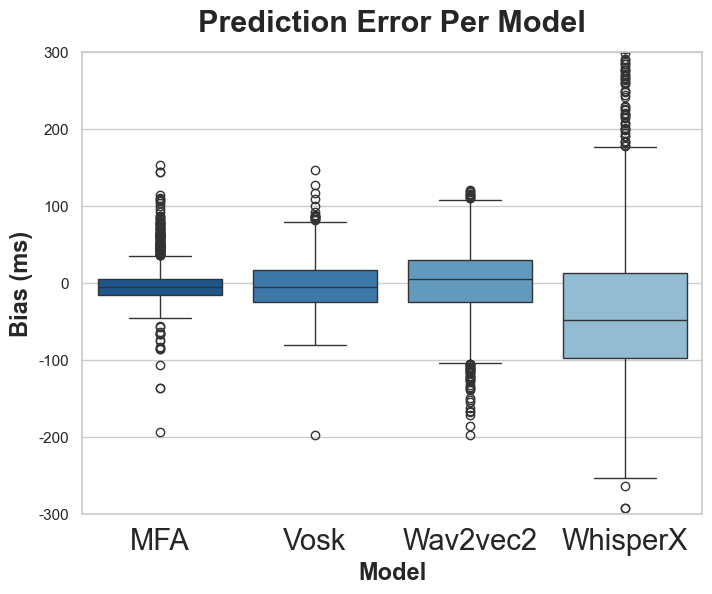

In [117]:
p = []
for col_name in x_vector.columns:
    col_data = x_vector[[col_name]]
    
    pred = cross_val_predict(model, col_data, y_vector, cv= kf)
    bias_each = y_vector - pred
    #print(manual_pred)
    #print(f"{col_name}", bias_each)
    p.append(bias_each)


df_per = pd.DataFrame(p).transpose()

#Rename columns
df_per.columns = ['MFA_Start', 'Vosk_Start', 'Wav2vec2_start', 'WhisperX_start']
new_labels = ['MFA', 'Vosk', 'Wav2vec2', 'WhisperX']

#Turn into format applicable for boxplots
df_long = df_per.melt(var_name='Model', value_name='Bias (ms)')

plt.figure(figsize=(8, 6))

palette = sns.color_palette("Blues")[::-1]

# Set showflier = False to remove outliers
sns.boxplot(x='Model', y= 'Bias (ms)', data=df_long, hue = 'Model', palette=palette)

# Covert error in milliseconds
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y*1000:.0f}"))

#Ensure all the ranges show
plt.ylim(-0.3, 0.3)
plt.xticks(ticks = [0,1,2,3], labels= new_labels, fontsize = 21)
plt.title("Prediction Error Per Model" , fontsize = 22, weight = 'bold', pad = 15)
plt.xlabel("Model", fontsize = 17, weight = 'bold')
plt.ylabel("Bias (ms)", fontsize = 17, weight = 'bold')

#plt.show()
plt.savefig('residuals per model.png')

bias = df_long.groupby('Model')['Bias (ms)'].median().abs().sort_values()
print("Models ranked by least bias (closest to manual):")
print(bias)




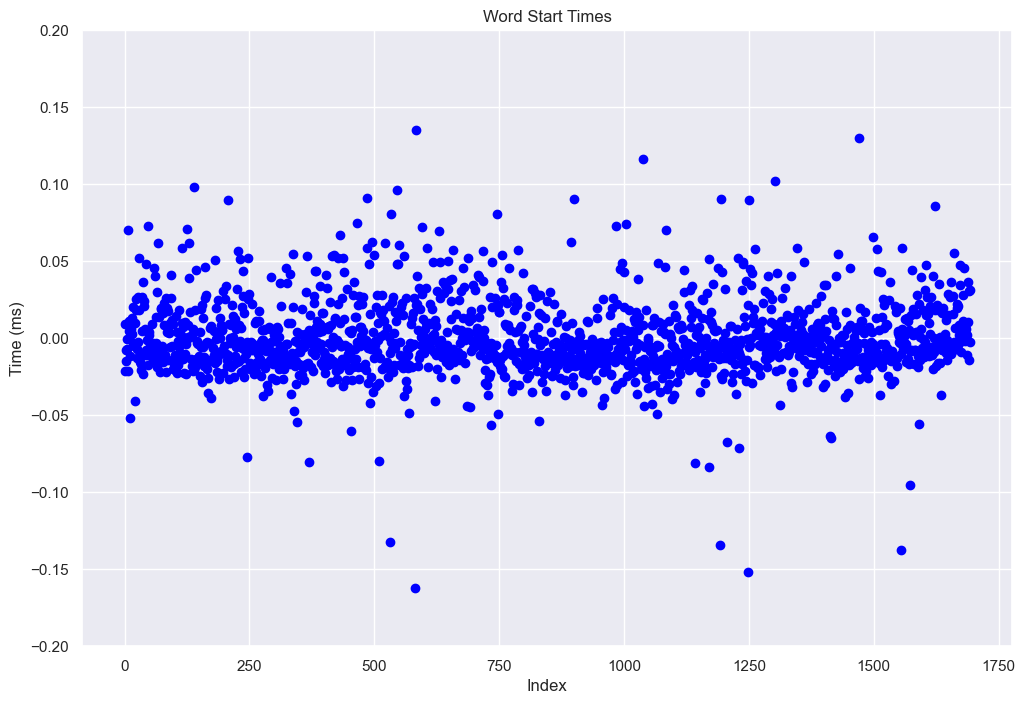

In [6]:

from collections import defaultdict

# Create unique word labels like "the-1", "the-2"
word_counts = defaultdict(int)
unique_words = []

for word in df_combined['Word']:
    word_counts[word] += 1

    if word_counts[word] > 1:
        unique_words.append(f"{word}-{word_counts[word]}")
    else: 
        unique_words.append(word)


df_combined['Word_idx'] = range(len(df_combined['Word']))

# Calculate differences from prediction
diff_vosk = (df_combined['Vosk_Start'][:100] - y_pred[:100])# * 1000  # in ms
diff_y = (y_vector[:100] - y_pred[:100]) #* 1000
diff = (y_vector[:100] - df_combined['Vosk_Start'][:100])

plt.figure(figsize=(12, 8))


plt.scatter(df_combined['Word_idx'] , (y_vector - y_pred) , color = 'blue')

plt.ylim(-0.2,0.2)
plt.xlabel("Index")
plt.ylabel("Time (ms)")
plt.title("Word Start Times")

plt.grid(True)

plt.show()





In [4]:
all_speaker = []
for filename in os.listdir(combined_dir):
    if filename.endswith('.csv'): #and 
    #if filename != 'F19_single105_combined.csv':
        path = os.path.join(combined_dir, filename)
        df = pd.read_csv(path)
        all_speaker.append(df)

df_combined = pd.concat(all_speaker, ignore_index = True)

NameError: name 'combined_dir' is not defined

In [17]:
for filename in os.listdir(combined_dir):
     if filename.lower().endswith('_combined_filtered.csv') :
        
        #make into a single path
        combined_path = os.path.join(combined_dir, filename)
        
        
        df_combinedla = pd.read_csv(combined_path).reset_index(drop=True)

    
        x_vector = df_combinedla[['WhisperX_start', 'Wav2vec2_start','MFA_Start', 'Vosk_Start']]
        
        y_vector = df_combinedla[['tmin']]
        
        #Using 70% data for training and 30% for testing
        #Random state is a constant integer so training data will be constant for every run
        x_vec_train, x_vec_test, y_vec_train, y_vec_test = train_test_split(x_vector, y_vector, test_size = 0.30, random_state = 42 )
        
        fitted_model = model.fit(x_vec_train, y_vec_train)
        
        score = model.score(x_vec_test, y_vec_test)
        coef = model.coef_
        intercept = model.intercept_
                
        cv_score = cross_val_score(model, x_vector, y_vector, cv=kf)
        y_pred = cross_val_predict(model, x_vector, y_vector, cv=kf)

        y_pred_df = pd.DataFrame(y_pred, columns=['Predicted start'])

        print(y_pred_df)

        final_df = pd.concat([df_combinedla, y_pred_df], axis=1)
        final_df = final_df.loc[:, ~final_df.columns.duplicated()]
        print(final_df.head())
        
        final_df.to_csv(combined_path, index= False)

     Predicted start
0           0.154596
1           0.259689
2           0.717480
3           0.874826
4           1.049234
..               ...
147        60.962931
148        61.084366
149        61.375521
150        61.520757
151        61.978524

[152 rows x 1 columns]
    Word  tmin  tmax  WhisperX_start  WhisperX_end  Wav2vec2_start  \
0    the  0.16  0.23           0.140         0.240           0.131   
1  bosom  0.23  0.70           0.300         0.681           0.276   
2     of  0.70  0.86           0.741         0.841           0.711   
3    one  0.86  1.04           0.941         1.041           0.886   
4     of  1.04  1.18           1.081         1.141           1.045   

   Wav2vec2_end  MFA_Start  MFA_End  Vosk_Start  Vosk_End  Predicted start  
0         0.174       0.15     0.24    0.075069      0.27         0.154596  
1         0.566       0.24     0.71    0.270000      0.72         0.259689  
2         0.755       0.71     0.86    0.720000      0.87         0.7174